In [96]:
import os
import pickle
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
from PcmPy.tmp__inference_cka import fit_CKA_individ, fit_CKA_group_crossval
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')

tmpFigDir = os.path.join('/Users', getpass.getuser(), 'Dropbox (Personal)', 'bmw1_Manuscript', 'figures', 'plots')


## Bimanual

decompose the bimanual pattern into contra, ipsi, and interaction components

### load data

In [ ]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

labels = ['flx_flx',    'flx_flxup',   'flx_extup',   'flx_ext',   'flx_extdn',   'flx_flxdn',
          'flxup_flx',  'flxup_flxup', 'flxup_extup', 'flxup_ext', 'flxup_extdn', 'flxup_flxdn',
          'extup_flx',  'extup_flxup', 'extup_extup', 'extup_ext', 'extup_extdn', 'extup_flxdn',
          'ext_flx',    'ext_flxup',   'ext_extup',   'ext_ext',   'ext_extdn',   'ext_flxdn',
          'extdn_flx',  'extdn_flxup', 'extdn_extup', 'extdn_ext', 'extdn_extdn', 'extdn_flxdn',
          'flxdn_flx',  'flxdn_flxup', 'flxdn_extup', 'flxdn_ext', 'flxdn_extdn', 'flxdn_flxdn']
cmap = 'RdBu_r'
ncond = 36

# load dataset:
file_path_save = os.path.join(analysisDir, f'pcm_dataset_bimanual_{region}.npz')
D = np.load(file_path_save, allow_pickle=True)
D = D['Y'].tolist()

# data g matrix:
N = len(D)
print(f'Number of subjects: {N}')
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))

# plt.rcParams.update({'font.size': 6})
# # visualize the estimated G:
# G_mean = np.mean(G_hat, axis=0)
# plt.figure(figsize=(6,6))
# vmin = -np.max(np.abs(G_mean))
# vmax = np.max(np.abs(G_mean))
# plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
# # draw lines every 6 conitions:
# for i in range(1,6):
#     plt.axhline(y=i*6-0.5, color='black', linestyle='--', linewidth=0.5)
#     plt.axvline(x=i*6-0.5, color='black', linestyle='--', linewidth=0.5)
# plt.colorbar()
# plt.title(f'Estimated G {region}')
# plt.xlabel('Conditions')
# plt.ylabel('Conditions')
# plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
# plt.yticks(ticks=np.arange(ncond), labels=labels)
# plt.tight_layout()
# plt.show()



Number of subjects: 24


### build and fit the components

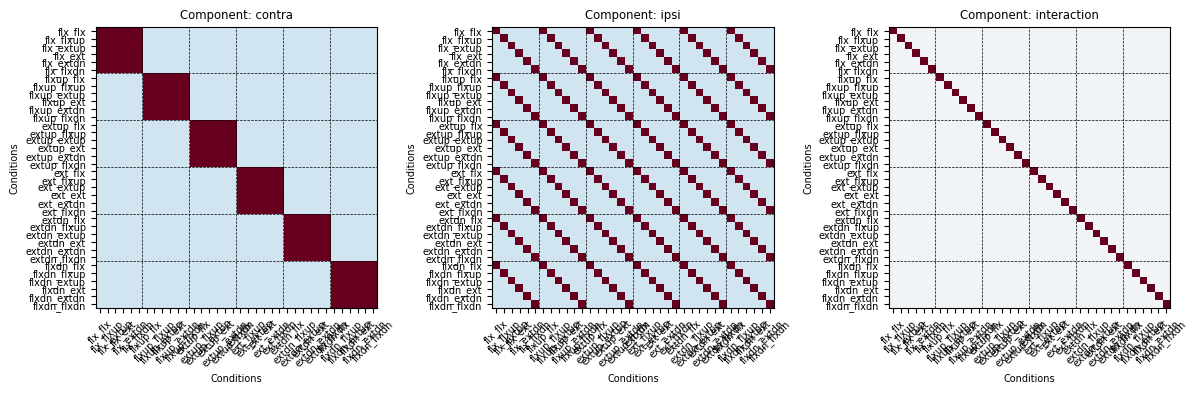

Fitting CKA individual...
Fitting PCM individual...


In [208]:
ncond = 36
G_model = {}

# Contra component:
cov = np.kron(np.eye(6), np.ones((6, 6)))
cov = pcm.centering(36) @ cov @ pcm.centering(36)
cov = cov/np.abs(np.trace(cov))/ncond
G_model['contra'] = cov

# Ipsilateral component:
cov = np.kron(np.ones((6, 6)), np.eye(6))
cov = pcm.centering(36) @ cov @ pcm.centering(36)
cov = cov/np.abs(np.trace(cov))/ncond
G_model['ipsi'] = cov  

# interaction term:
cov = np.eye(ncond)
cov = pcm.centering(36) @ cov @ pcm.centering(36)
cov = cov/np.abs(np.trace(cov))/ncond
G_model['interaction'] = cov

M = []
M.append(pcm.ComponentModel('all', [G_model['contra'],G_model['ipsi'], G_model['interaction']]))

# visualize model components:
ncomponent = len(G_model.keys())
fig, axes = plt.subplots(1, ncomponent, figsize=(4*ncomponent,4))
for i, key in enumerate(G_model.keys()):
    vmin = -np.max(np.abs(G_model[key]))
    vmax = np.max(np.abs(G_model[key]))
    axes[i].imshow(G_model[key], cmap='RdBu_r', vmin=vmin, vmax=vmax)
    # draw lines every 6 conitions:
    for j in range(1,6):
        axes[i].axhline(y=j*6-0.55, color='black', linestyle='--', linewidth=0.5)
        axes[i].axvline(x=j*6-0.55, color='black', linestyle='--', linewidth=0.5)
    axes[i].set_title(f'Component: {key}')
    axes[i].set_xlabel('Conditions')
    axes[i].set_ylabel('Conditions')
    axes[i].set_xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
    axes[i].set_yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()

# fit CKA individual:
print('Fitting CKA individual...')
T_CKA_ind, theta_CKA_ind, AIC = fit_CKA_individ(D, M, verbose=False, AIC=True)

# fit PCM individual:
print('Fitting PCM individual...')
T_PCM_ind, theta_PCM_ind = pcm.fit_model_individ(D, M, fit_scale=False, verbose=False)



### variance of components

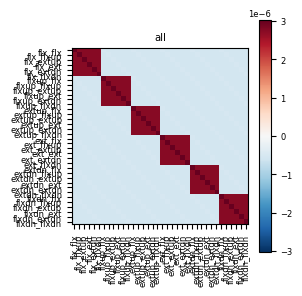

4


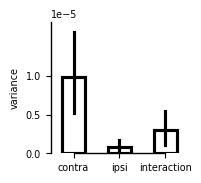

In [ ]:
theta = theta_PCM_ind

nmodels = len(M)
# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, nmodels, figsize=(3*nmodels,3))
th = []
for m in range(nmodels):
    th_tmp = np.exp(theta[m])
    th_tmp = np.median(th_tmp, axis=1)
    th_tmp = np.log(th_tmp)
    th.append(th_tmp)
    
    G_pred = M[m].predict(th[m][:M[m].n_param])[0]
    vmin = -np.max(np.abs(G_pred))
    vmax = np.max(np.abs(G_pred))
    ax.imshow(G_pred, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax.set_xticks(list(range(ncond)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(list(range(ncond)))
    ax.set_yticklabels(labels)
    ax.set_title(f'{M[m].name}')
    plt.colorbar(ax.imshow(G_pred, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
plt.tight_layout()
plt.show()

print(len(theta[0]))

# variance of components:
var_contra = np.trace(G_model['contra'])/ncond * np.exp(theta[0][0])
var_ipsi = np.trace(G_model['ipsi'])/ncond * np.exp(theta[0][1])
var_interaction = np.trace(G_model['interaction'])/ncond * np.exp(theta[0][2])

# boxplot:
var_df = {'sn': [], 'component': [], 'variance': []}
for i in range(var_contra.shape[0]):
    # total_var = var_contra[i] + var_ipsi[i] + var_interaction[i]
    total_var = 1

    var_df['sn'].append(i)
    var_df['component'].append('contra')
    var_df['variance'].append(var_contra[i]/total_var)
    
    var_df['sn'].append(i)
    var_df['component'].append('ipsi')
    var_df['variance'].append(var_ipsi[i]/total_var)
    
    var_df['sn'].append(i)
    var_df['component'].append('interaction')
    var_df['variance'].append(var_interaction[i]/total_var)
    
    # total_var = np.trace(G_hat[i,:,:])/ncond
    # var_df['sn'].append(i)
    # var_df['component'].append('total')
    # var_df['variance'].append(total_var)
var_df = pd.DataFrame(var_df)

plt.rcParams.update({'font.size': 7})
fig, ax = plt.subplots(figsize=(2,2))
sns.barplot(x='component', y='variance', data=var_df, width=0.5, color='k', fill=False, ax=ax)
ax.set_yticks(np.array([0, 0.5, 1.0])*1e-5)
ax.set_ylim(0, 1.7e-5)
plt.tight_layout()
utils.please.make_it_pretty(ax=ax)
ax.set_xlabel('')
plt.savefig(f'../figures/VarDecompose/bimanual_{region}.pdf', bbox_inches="tight")
plt.show()



### run all regions

In [59]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

labels = ['flx_flx',    'flx_flxup',   'flx_extup',   'flx_ext',   'flx_extdn',   'flx_flxdn',
          'flxup_flx',  'flxup_flxup', 'flxup_extup', 'flxup_ext', 'flxup_extdn', 'flxup_flxdn',
          'extup_flx',  'extup_flxup', 'extup_extup', 'extup_ext', 'extup_extdn', 'extup_flxdn',
          'ext_flx',    'ext_flxup',   'ext_extup',   'ext_ext',   'ext_extdn',   'ext_flxdn',
          'extdn_flx',  'extdn_flxup', 'extdn_extup', 'extdn_ext', 'extdn_extdn', 'extdn_flxdn',
          'flxdn_flx',  'flxdn_flxup', 'flxdn_extup', 'flxdn_ext', 'flxdn_extdn', 'flxdn_flxdn']
cmap = 'RdBu_r'
ncond = 36

G_model = {}
# Contra component:
cov = np.kron(np.eye(6), np.ones((6, 6)))
cov = pcm.centering(36) @ cov @ pcm.centering(36)
cov = cov/np.abs(np.trace(cov))/ncond
G_model['contra'] = cov

# Ipsilateral component:
cov = np.kron(np.ones((6, 6)), np.eye(6))
cov = pcm.centering(36) @ cov @ pcm.centering(36)
cov = cov/np.abs(np.trace(cov))/ncond
G_model['ipsi'] = cov  

# interaction term:
cov = np.eye(ncond)
cov = pcm.centering(36) @ cov @ pcm.centering(36)
cov = cov/np.abs(np.trace(cov))/ncond
G_model['interaction'] = cov

# OLS components:
# Generate the three model components, each one as a fixed model
A = np.zeros((ncond, 6))
for i in range(6):
    A[i*6:(i+1)*6, i] = 1.0
B = np.tile(np.eye(6), (6, 1))
I = np.eye(ncond)
# Orthogonalize the interaction effect
X = np.c_[A, B]
Io = I - X @ np.linalg.pinv(X) @ I

# Now Build the second moment matrix and create the full model
# for data generation:
Gc = np.zeros((3, ncond, ncond))
Gc[0] = A @ A.T # contra
Gc[1] = B @ B.T # ipsi
Gc[2] = Io @ Io.T # interaction

var_df = {'region': [], 'hem': [], 'sn': [], 'component': [], 'variance': [], 'weight_ols': []}
for region in regions:
    # load dataset:
    file_path_save = os.path.join(analysisDir, f'pcm_dataset_bimanual_{region}.npz')
    D = np.load(file_path_save, allow_pickle=True)
    hemisphere = D['hemisphere'].tolist()
    D = D['Y'].tolist()

    M = []
    M.append(pcm.ComponentModel('all', [G_model['contra'],G_model['ipsi'], G_model['interaction']]))

    # fit CKA individual:
    # print('Fitting CKA individual...')
    # T_CKA_ind, theta_CKA_ind, AIC = fit_CKA_individ(D, M, verbose=False, AIC=True)

    # ================================ fit PCM individual ================================
    print(f'{region} - Fitting PCM individual...')
    T_PCM_ind, theta_PCM_ind = pcm.fit_model_individ(D, M, fit_scale=False, verbose=False)

    # ================================ fit OLS individual ================================
    # estimate G_hat:
    G_hat = np.zeros((len(D), ncond, ncond))
    for i in range(len(D)):
        G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                                D[i].obs_descriptors['cond_vec'],
                                                D[i].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))
    X = np.vstack([Gc[0].flatten(), Gc[1].flatten(), Gc[2].flatten()]).T
    W = []
    for i in range(len(D)):
        tmp_w = np.linalg.pinv((X.T@X)) @ X.T @ G_hat[i].flatten()
        W.append(tmp_w)
    W = np.array(W)

    # ================================ estimate variance ================================
    theta = theta_PCM_ind
    # sqrt variance of components:
    var_contra = np.trace(G_model['contra'])/ncond * np.exp(theta[0][0])
    var_ipsi = np.trace(G_model['ipsi'])/ncond * np.exp(theta[0][1])
    var_interaction = np.trace(G_model['interaction'])/ncond * np.exp(theta[0][2])

    # OLS variances:
    ols_contra = W[:,0] * np.trace(Gc[0])/ncond
    ols_ipsi = W[:,1] * np.trace(Gc[1])/ncond
    ols_interaction = W[:,2] * np.trace(Gc[2])/ncond
    
    # boxplot:
    for i in range(var_contra.shape[0]):
        var_df['region'].append(region)
        var_df['hem'].append(hemisphere[i])
        var_df['sn'].append(i)
        var_df['component'].append('contra')
        var_df['variance'].append(var_contra[i])
        var_df['weight_ols'].append(ols_contra[i])
        
        var_df['region'].append(region)
        var_df['hem'].append(hemisphere[i])
        var_df['sn'].append(i)
        var_df['component'].append('ipsi')
        var_df['variance'].append(var_ipsi[i])
        var_df['weight_ols'].append(ols_ipsi[i])
        
        var_df['region'].append(region)
        var_df['hem'].append(hemisphere[i])
        var_df['sn'].append(i)
        var_df['component'].append('interaction')
        var_df['variance'].append(var_interaction[i])
        var_df['weight_ols'].append(ols_interaction[i])

var_df = pd.DataFrame(var_df)
var_df.to_csv(os.path.join(analysisDir, 'VarDecompose_bimanual.csv'), index=False)



M1 - Fitting PCM individual...
S1 - Fitting PCM individual...
PMd - Fitting PCM individual...
PMv - Fitting PCM individual...
SMA - Fitting PCM individual...
SPLa - Fitting PCM individual...
SPLp - Fitting PCM individual...
V1 - Fitting PCM individual...


### plot

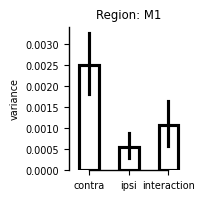

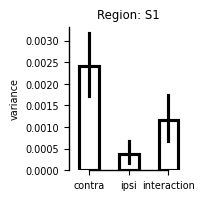

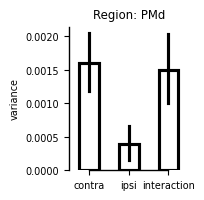

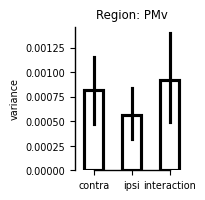

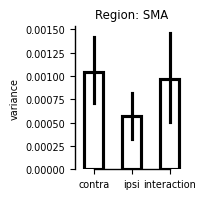

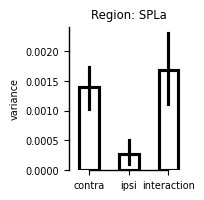

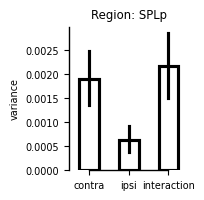

In [37]:
var_df = pd.read_csv(os.path.join(analysisDir, 'VarDecompose_bimanual.csv'))
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp']

for region in regions:
    var_df_region = var_df[var_df['region'] == region]
    plt.rcParams.update({'font.size': 7})
    fig, ax = plt.subplots(figsize=(2,2))
    sns.barplot(x='component', y='variance', data=var_df_region, width=0.5, color='k', fill=False, ax=ax)
    # ax.set_yticks(np.array([0, 0.5, 1.0, 1.5])*1e-5)
    # ax.set_ylim(0, 2.2e-5)
    plt.tight_layout()
    utils.please.make_it_pretty(ax=ax)
    ax.set_xlabel('')
    ax.set_title(f'Region: {region}')
    # plt.savefig(os.path.join(tmpFigDir, f'VarDecompose_bimanual_{region}.pdf'), bbox_inches="tight")
    plt.show()


### ANOVA on components

In [100]:
from statsmodels.stats.anova import AnovaRM
# rm anova on var_df:
anova = AnovaRM(var_df, 'variance', subject='sn', within=['component']).fit()
print(anova)
# Extract p-values with scientific notation
# print("\nP-values in scientific notation:")
# for index, row in anova.anova_table.iterrows():
#     print(f"{index}: F = {row['F Value']:.4f}, p = {row['Pr > F']:.3e}")

# post-hoc t-tests:
# contra vs ipsi
t_stat, p_val = stats.ttest_rel(var_contra, var_ipsi, alternative='two-sided')
print(f'\ncontra vs ipsi: t = {t_stat:.4f}, p = {p_val:.3e}')
# contra vs interaction
t_stat, p_val = stats.ttest_rel(var_contra, var_interaction, alternative='two-sided')
print(f'contra vs interaction: t = {t_stat:.4f}, p = {p_val:.3e}')
# ipsi vs interaction
t_stat, p_val = stats.ttest_rel(var_ipsi, var_interaction, alternative='two-sided')
print(f'ipsi vs interaction: t = {t_stat:.4f}, p = {p_val:.3e}')

# t-test component > 0:
t_stat, p_val = stats.ttest_1samp(var_contra, 0, alternative='greater')
print(f'\ncontra > 0: t = {t_stat:.4f}, p = {p_val:.3e}')
t_stat, p_val = stats.ttest_1samp(var_ipsi, 0, alternative='greater')
print(f'ipsi > 0: t = {t_stat:.4f}, p = {p_val:.3e}')
t_stat, p_val = stats.ttest_1samp(var_interaction, 0, alternative='greater')
print(f'interaction > 0: t = {t_stat:.4f}, p = {p_val:.3e}')



                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
component  8.6425 2.0000 46.0000 0.0007


contra vs ipsi: t = 3.2583, p = 3.460e-03
contra vs interaction: t = 2.6278, p = 1.504e-02
ipsi vs interaction: t = -2.2496, p = 3.435e-02

contra > 0: t = 3.4609, p = 1.060e-03
ipsi > 0: t = 1.6974, p = 5.156e-02
interaction > 0: t = 2.9437, p = 3.646e-03


## Unimanual

decomposing the unimanual activity patterns into contra and ipsi

### load dataset

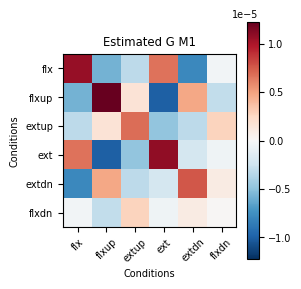

In [ ]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
ncond = 6

# load dataset:
file_path_save = os.path.join(analysisDir, f'pcm_dataset_6by6_{region}.npz')
D = np.load(file_path_save, allow_pickle=True)
identifier = D['identifier']
D = D['Y'].tolist()

# data g matrix:
N = len(D)
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))

# visualize the estimated G:
G_mean = np.mean(G_hat[0:48,:,:], axis=0)
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'Estimated G {region}')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()



### variance of components

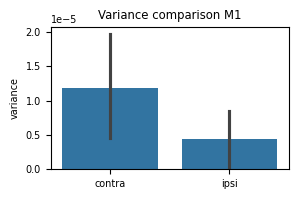

In [201]:
contra_idx = (identifier == 'contra').flatten()
ipsi_idx = (identifier == 'ipsi').flatten()

contra_G = G_hat[contra_idx,:,:]
ipsi_G = G_hat[ipsi_idx,:,:]

# variance measurement:
var_df = {'sn': [], 'component': [], 'variance': []}
for i in range(contra_G.shape[0]):
    var_df['sn'].append(i)
    var_df['component'].append('contra')
    var_df['variance'].append(np.trace(contra_G[i,:,:])/ncond)
    
    var_df['sn'].append(i)
    var_df['component'].append('ipsi')
    var_df['variance'].append(np.trace(ipsi_G[i,:,:])/ncond)
var_df = pd.DataFrame(var_df)

# barplot:
fig, ax = plt.subplots(figsize=(3,2))
sns.barplot(x='component', y='variance', data=var_df, ax=ax)
plt.title(f'Variance comparison {region}')
plt.xlabel('')
plt.tight_layout()
plt.show()



### run all regions

In [93]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
ncond = 6

var_df = {'region': [], 'hem': [], 'sn': [], 'component': [], 'variance': []}
for region in regions:
    # load dataset:
    file_path_save = os.path.join(analysisDir, f'pcm_dataset_6by6_{region}.npz')
    D = np.load(file_path_save, allow_pickle=True)
    hemisphere = D['hemisphere'].tolist()
    identifier = D['identifier']
    D = D['Y'].tolist()

    N = len(D)
    G_hat = np.zeros((N, ncond, ncond))
    Dist = np.zeros((N,ncond,ncond))
    for i in range(N):
        G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                                D[i].obs_descriptors['cond_vec'],
                                                D[i].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))

    contra_idx = (identifier == 'contra').flatten()
    ipsi_idx = (identifier == 'ipsi').flatten()

    contra_G = G_hat[contra_idx,:,:]
    ipsi_G = G_hat[ipsi_idx,:,:]

    # variance measurement:
    for i in range(contra_G.shape[0]):
        var_df['region'].append(region)
        var_df['hem'].append(hemisphere[i])
        var_df['sn'].append(i)
        var_df['component'].append('contra')
        var_df['variance'].append(np.trace(contra_G[i,:,:])/ncond)
        
        var_df['region'].append(region)
        var_df['hem'].append(hemisphere[i])
        var_df['sn'].append(i)
        var_df['component'].append('ipsi')
        var_df['variance'].append(np.trace(ipsi_G[i,:,:])/ncond)
    
var_df = pd.DataFrame(var_df)
var_df.to_csv(os.path.join(analysisDir, 'VarDecompose_unimanual.csv'), index=False)    



### plot

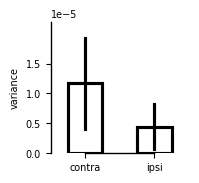

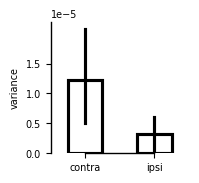

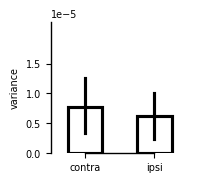

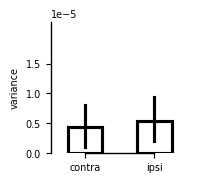

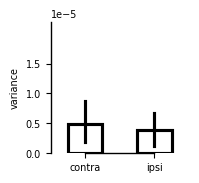

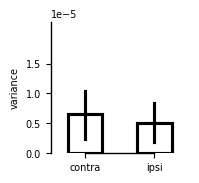

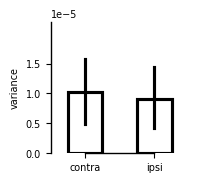

In [4]:
var_df = pd.read_csv(os.path.join(analysisDir, 'VarDecompose_unimanual.csv'))
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp']

for region in regions:
    var_df_region = var_df[var_df['region'] == region]
    plt.rcParams.update({'font.size': 7})
    fig, ax = plt.subplots(figsize=(2,2))
    sns.barplot(x='component', y='variance', data=var_df_region, width=0.5, color='k', fill=False, ax=ax)
    ax.set_yticks(np.array([0, 0.5, 1.0, 1.5])*1e-5)
    ax.set_ylim(0, 2.2e-5)
    plt.tight_layout()
    utils.please.make_it_pretty(ax=ax)
    ax.set_xlabel('')
    # plt.savefig(f'../figures/VarDecompose/unimanual_{region}.pdf', bbox_inches="tight")
    plt.savefig(os.path.join(tmpFigDir, f'VarDecompose_unimanual_{region}.pdf'), bbox_inches="tight")
    plt.show()



### ttest

ttest contra>0 and ipsi>0 then fdr correction for 8 regions

In [ ]:
results_contra = []
results_ipsi = []
for region in regions:
    var_df_region = var_df[var_df['region'] == region]
    contra_var = var_df_region[var_df_region['component'] == 'contra']['variance'].values
    ipsi_var = var_df_region[var_df_region['component'] == 'ipsi']['variance'].values

    # t-test contra > 0:
    t_stat, p_val = stats.ttest_1samp(contra_var, 0, alternative='greater')
    results_contra.append({
            'region': region,
            't_stat': t_stat,
            'p_unc': p_val
        })

    # t-test ipsi > 0:
    t_stat, p_val = stats.ttest_1samp(ipsi_var, 0, alternative='greater')
    results_ipsi.append({
            'region': region,
            't_stat': t_stat,
            'p_unc': p_val
        })

results_contra = pd.DataFrame(results_contra)
results_ipsi = pd.DataFrame(results_ipsi)

# multiple comparison correction:
from statsmodels.stats.multitest import multipletests
# contra:
reject, p_corr, _, _ = multipletests(results_contra['p_unc'], alpha=0.05, method='fdr_bh')
results_contra['p_corr'] = p_corr
results_contra['reject_H0'] = reject
print('Contra results:')
print(results_contra)
# ipsi:
reject, p_corr, _, _ = multipletests(results_ipsi['p_unc'], alpha=0.05, method='fdr_bh')
results_ipsi['p_corr'] = p_corr
results_ipsi['reject_H0'] = reject
print('\nIpsi results:')
print(results_ipsi)



Contra results:
  region    t_stat     p_unc    p_corr  reject_H0
0     M1  3.506414  0.000949  0.001237       True
1     S1  3.460881  0.001060  0.001237       True
2    PMd  4.259745  0.000147  0.000435       True
3    PMv  3.189918  0.002038  0.002038       True
4    SMA  3.588167  0.000777  0.001237       True
5   SPLa  4.664804  0.000054  0.000376       True
6   SPLp  4.165249  0.000186  0.000435       True

Ipsi results:
  region    t_stat     p_unc    p_corr  reject_H0
0     M1  2.217910  0.018358  0.032126       True
1     S1  1.697386  0.051558  0.060151      False
2    PMd  1.960463  0.031082  0.043515       True
3    PMv  3.236998  0.001821  0.006373       True
4    SMA  3.400168  0.001229  0.006373       True
5   SPLa  1.416264  0.085050  0.085050      False
6   SPLp  2.978901  0.003357  0.007834       True


## PCM Var Plot

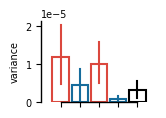

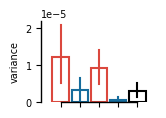

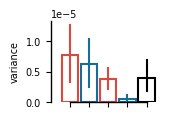

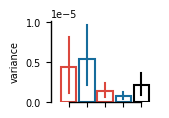

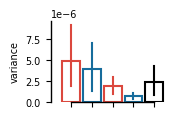

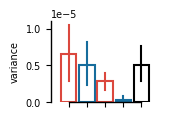

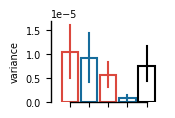

In [75]:
var_uni = pd.read_csv(os.path.join(analysisDir, 'VarDecompose_unimanual.csv'))
var_bi = pd.read_csv(os.path.join(analysisDir, 'VarDecompose_bimanual.csv'))

# change var_uni component names:
var_uni['component'] = var_uni['component'].replace({'contra': 'uni_contra', 'ipsi': 'uni_ipsi'})

# Combine both dataframes:
var_df = pd.concat([var_uni, var_bi], ignore_index=True)

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp']
for region in regions:
    var_df_region = var_df[var_df['region'] == region]
    plt.rcParams.update({'font.size': 7})
    fig, ax = plt.subplots(figsize=(1.8,1.5))
    sns.barplot(x='component', y='variance', hue='component', data=var_df_region, width=0.5, gap=-0.7, linewidth=1.5, err_kws={'linewidth':1.5},
                palette=['#db483e', '#166C9C', '#db483e', '#166C9C', '#000000'], fill=False, ax=ax)
    # ax.set_yticks(np.array([0, 0.5, 1.0, 1.5])*1e-5)
    # ax.set_ylim(0, 2.2e-5)
    ax.set_xlim(-1, 5)
    plt.tight_layout()
    utils.please.make_it_pretty(ax=ax)
    ax.set_xlabel('')
    ax.set_xticklabels('')
    plt.savefig(os.path.join(tmpFigDir, 'VarDecompose', f'VarDecompose_combined_{region}.pdf'), bbox_inches="tight")
    plt.show()



## OLS var PLOT

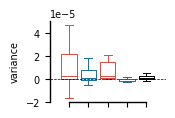

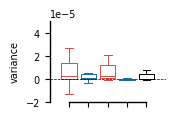

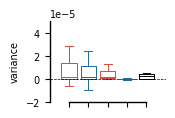

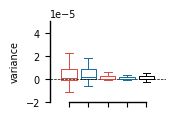

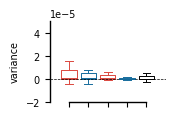

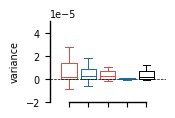

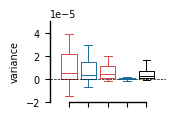

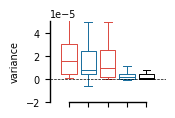

In [94]:
var_uni = pd.read_csv(os.path.join(analysisDir, 'VarDecompose_unimanual.csv'))
var_bi = pd.read_csv(os.path.join(analysisDir, 'VarDecompose_bimanual.csv'))
var_bi['variance'] = var_bi['weight_ols'] # replce the PCM var with OLS 

# change var_uni component names:
var_uni['component'] = var_uni['component'].replace({'contra': 'uni_contra', 'ipsi': 'uni_ipsi'})

# Combine both dataframes:
var_df = pd.concat([var_uni, var_bi], ignore_index=True)

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
for region in regions:
    var_df_region = var_df[var_df['region'] == region]
    plt.rcParams.update({'font.size': 7})
    fig, ax = plt.subplots(figsize=(1.8,1.5))
    sns.boxplot(x='component', y='variance', hue='component', data=var_df_region, width=0.5, gap=-0.6, linewidth=0.7, fliersize=0,
                palette=['#db483e', '#166C9C', '#db483e', '#166C9C', '#000000'], fill=False, ax=ax)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    # ax.set_yticks(np.array([0, 0.5, 1.0, 1.5])*1e-5)
    ax.set_ylim(-2e-5, 5e-5)
    ax.set_xlim(-1, 5)
    plt.tight_layout()
    utils.please.make_it_pretty(ax=ax)
    ax.set_xlabel('')
    ax.set_xticklabels('')
    plt.savefig(os.path.join(tmpFigDir, 'VarDecompose', f'VarDecompose_combined_{region}.pdf'), bbox_inches="tight")
    plt.show()



## STATS

### components > 0

the ols weights are tested against 0 to infer whether it exists or not. For unimanual the trace of G is tested > 0

In [95]:
var_bi = pd.read_csv(os.path.join(analysisDir, 'VarDecompose_bimanual.csv'))
var_uni = pd.read_csv(os.path.join(analysisDir, 'VarDecompose_unimanual.csv'))
var_bi['variance'] = var_bi['weight_ols'] # replace the PCM var with OLS 
# change var_uni component names:
var_uni['component'] = var_uni['component'].replace({'contra': 'uni_contra', 'ipsi': 'uni_ipsi'})
# Combine both dataframes:
var_df = pd.concat([var_uni, var_bi], ignore_index=True)

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

pval_df = {'region': [], 'component': [], 't_stat': [], 'p_unc': []}
components = var_df['component'].unique()
for region in regions:
    for comp in components:
        tmp = var_df[(var_df['region'] == region) & (var_df['component'] == comp)]
        # get the variance values:
        var_values = tmp['variance'].values
        # transform the values:
        var_values = np.sign(var_values) * np.sqrt(np.abs(var_values))
        # t-test > 0:
        t_stat, p_val = stats.ttest_1samp(var_values, 0, alternative='greater')
        pval_df['region'].append(region)
        pval_df['component'].append(comp)
        pval_df['t_stat'].append(t_stat)
        pval_df['p_unc'].append(p_val)

pval_df = pd.DataFrame(pval_df)

# correct across regions:
components = pval_df['component'].unique()
for component in components:
    comp_idx = (pval_df['component'] == component)
    reject, p_corr, _, _ = multipletests(pval_df.loc[comp_idx, 'p_unc'], alpha=0.05, method='fdr_bh')
    pval_df.loc[comp_idx, 'p_corr'] = p_corr
    pval_df.loc[comp_idx, 'reject_H0'] = reject

print('Bimanual OLS weight results:')
# sort based on component:
pval_df = pval_df.sort_values(by=['component', 'region'])
print(pval_df)



Bimanual OLS weight results:
   region    component    t_stat         p_unc        p_corr reject_H0
2      M1       contra  6.356392  8.695707e-07  2.318855e-06      True
12    PMd       contra  6.586174  5.075975e-07  2.030390e-06      True
17    PMv       contra  3.408728  1.203528e-03  1.203528e-03      True
7      S1       contra  5.887972  2.654811e-06  3.856878e-06      True
22    SMA       contra  4.148326  1.945062e-04  2.222928e-04      True
27   SPLa       contra  5.852367  2.892658e-06  3.856878e-06      True
32   SPLp       contra  5.987380  2.090730e-06  3.856878e-06      True
37     V1       contra  7.309718  9.728975e-08  7.783180e-07      True
4      M1  interaction  3.536553  8.817801e-04  1.175707e-03      True
14    PMd  interaction  5.120151  1.732119e-05  3.464238e-05      True
19    PMv  interaction  2.349667  1.387233e-02  1.387233e-02      True
9      S1  interaction  4.265501  1.452598e-04  2.324156e-04      True
24    SMA  interaction  2.477365  1.050792e-02  

### bimanual components against each other

testing the variance of contra, ipsi, and interaction against each other. Here we use the PCM fitted weights as they are not biased like OLS (refer to the simulations below to see how OLS biases the component weights).

In [65]:
from statsmodels.stats.anova import AnovaRM
var_bi = pd.read_csv(os.path.join(analysisDir, 'VarDecompose_bimanual.csv'))
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp']
pval_df = {'region': [], 'test': [], 't_stat': [], 'p_unc': []}

# anova:
anova = AnovaRM(var_bi, 'variance', subject='sn', within=['component','region']).fit()
print(anova)

# post-hoc t-tests per region:
for region in regions:
    var_df_region = var_bi[var_bi['region'] == region]
    var_contra = var_df_region[var_df_region['component'] == 'contra']['variance'].values
    var_ipsi = var_df_region[var_df_region['component'] == 'ipsi']['variance'].values
    var_interaction = var_df_region[var_df_region['component'] == 'interaction']['variance'].values

    # contra vs ipsi
    t_stat1, p_val1 = stats.ttest_rel(var_contra, var_ipsi, alternative='two-sided')
    # contra vs interaction
    t_stat2, p_val2 = stats.ttest_rel(var_contra, var_interaction, alternative='two-sided')
    # ipsi vs interaction
    t_stat3, p_val3 = stats.ttest_rel(var_ipsi, var_interaction, alternative='two-sided')

    pval_df['region'].append(region)
    pval_df['test'].append('contra_vs_ipsi')
    pval_df['t_stat'].append(t_stat1)
    pval_df['p_unc'].append(p_val1)
    pval_df['region'].append(region)
    pval_df['test'].append('contra_vs_interaction')
    pval_df['t_stat'].append(t_stat2)
    pval_df['p_unc'].append(p_val2)
    pval_df['region'].append(region)
    pval_df['test'].append('ipsi_vs_interaction')
    pval_df['t_stat'].append(t_stat3)
    pval_df['p_unc'].append(p_val3)
    
pval_df = pd.DataFrame(pval_df)

# multiple comparison correction across regions per test:
tests = pval_df['test'].unique()
for test in tests:
    test_idx = (pval_df['test'] == test)
    reject, p_corr, _, _ = multipletests(pval_df.loc[test_idx, 'p_unc'], alpha=0.05, method='fdr_bh')
    pval_df.loc[test_idx, 'p_corr'] = p_corr
    pval_df.loc[test_idx, 'reject_H0'] = reject
print('\nPost-hoc t-test results:')
print(pval_df)




                     Anova
                 F Value  Num DF  Den DF  Pr > F
------------------------------------------------
component         8.9719  2.0000  46.0000 0.0005
region           18.6989  7.0000 161.0000 0.0000
component:region 10.3374 14.0000 322.0000 0.0000


Post-hoc t-test results:
   region                   test    t_stat     p_unc    p_corr reject_H0
0      M1         contra_vs_ipsi  3.240271  0.003613  0.005058      True
1      M1  contra_vs_interaction  2.766711  0.010977  0.052648     False
2      M1    ipsi_vs_interaction -1.917940  0.067618  0.078888     False
3      S1         contra_vs_ipsi  3.258329  0.003460  0.005058      True
4      S1  contra_vs_interaction  2.627790  0.015042  0.052648     False
5      S1    ipsi_vs_interaction -2.249560  0.034348  0.060108     False
6     PMd         contra_vs_ipsi  3.540876  0.001745  0.004072      True
7     PMd  contra_vs_interaction -0.113479  0.910635  0.910635     False
8     PMd    ipsi_vs_interaction -2.504326  

### unimanual vs bimanual copmonent

In [66]:
var_uni = pd.read_csv(os.path.join(analysisDir, 'VarDecompose_unimanual.csv'))
var_bi = pd.read_csv(os.path.join(analysisDir, 'VarDecompose_bimanual.csv'))

pval_df = {'region': [], 'test': [], 't_stat': [], 'p_unc': []}
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp']
for region in regions:
    var_df_uni_region = var_uni[var_uni['region'] == region]
    var_df_bi_region = var_bi[var_bi['region'] == region]
    
    # contra:
    uni_contra = var_df_uni_region[var_df_uni_region['component'] == 'contra']['variance'].values
    bi_contra = var_df_bi_region[var_df_bi_region['component'] == 'contra']['variance'].values
    # ipsi:
    uni_ipsi = var_df_uni_region[var_df_uni_region['component'] == 'ipsi']['variance'].values
    bi_ipsi = var_df_bi_region[var_df_bi_region['component'] == 'ipsi']['variance'].values

    # t-test contra uni vs bi
    t_stat1, p_val1 = stats.ttest_rel(uni_contra, bi_contra, alternative='two-sided')
    # t-test ipsi uni vs bi
    t_stat2, p_val2 = stats.ttest_rel(uni_ipsi, bi_ipsi, alternative='two-sided')

    pval_df['region'].append(region)
    pval_df['test'].append('contra_uni_vs_bi')
    pval_df['t_stat'].append(t_stat1)
    pval_df['p_unc'].append(p_val1)
    pval_df['region'].append(region)
    pval_df['test'].append('ipsi_uni_vs_bi')
    pval_df['t_stat'].append(t_stat2)
    pval_df['p_unc'].append(p_val2)

# multiple comparison correction across regions per test:
pval_df = pd.DataFrame(pval_df)
tests = pval_df['test'].unique()
for test in tests:
    test_idx = (pval_df['test'] == test)
    reject, p_corr, _, _ = multipletests(pval_df.loc[test_idx, 'p_unc'], alpha=0.05, method='fdr_bh')
    pval_df.loc[test_idx, 'p_corr'] = p_corr
    pval_df.loc[test_idx, 'reject_H0'] = reject 
print('\nUni vs Bi t-test results:')
print(pval_df)




Uni vs Bi t-test results:
   region              test    t_stat     p_unc    p_corr reject_H0
0      M1  contra_uni_vs_bi  0.702367  0.489498  0.489498     False
1      M1    ipsi_uni_vs_bi  1.828574  0.080462  0.080462     False
2      S1  contra_uni_vs_bi  0.928828  0.362624  0.423062     False
3      S1    ipsi_uni_vs_bi  1.964485  0.061669  0.071947     False
4     PMd  contra_uni_vs_bi  1.866153  0.074823  0.130941     False
5     PMd    ipsi_uni_vs_bi  2.820330  0.009705  0.022646      True
6     PMv  contra_uni_vs_bi  1.953709  0.063003  0.130941     False
7     PMv    ipsi_uni_vs_bi  2.483583  0.020730  0.036278      True
8     SMA  contra_uni_vs_bi  1.691955  0.104161  0.145825     False
9     SMA    ipsi_uni_vs_bi  2.352211  0.027593  0.038630      True
10   SPLa  contra_uni_vs_bi  2.091745  0.047698  0.130941     False
11   SPLa    ipsi_uni_vs_bi  2.884833  0.008361  0.022646      True
12   SPLp  contra_uni_vs_bi  2.111771  0.045778  0.130941     False
13   SPLp    ipsi_uni

## Simulation

### Is averaging equivalent to OLS?

#### generate data

1.428571428571428
1.4285714285714277


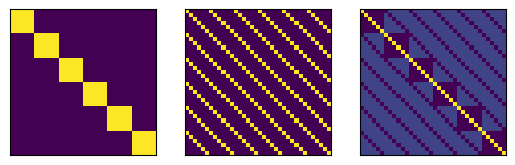

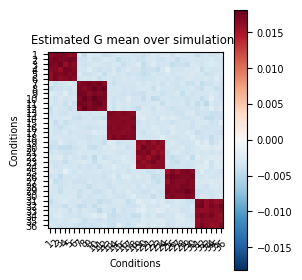

In [ ]:
np.random.seed(0)
ncond = 36

nsim = 200
s = [0.02]*nsim
cond_vec, part_vec = pcm.sim.make_design(n_cond=ncond, n_part=10)
theta_true = np.array([0,-5,-10e10])


# Generate the three model components, each one as a fixed model
A = np.zeros((ncond, 6))
for i in range(6):
    A[i*6:(i+1)*6, i] = 1.0
B = np.tile(np.eye(6), (6, 1))
I = np.eye(ncond)
# Orthogonalize the interaction effect
X = np.c_[A, B]
Io = I - X @ np.linalg.pinv(X) @ I

# Now Build the second moment matrix and create the full model
# for data generation:
Gc = np.zeros((3, ncond, ncond))
Gc[0] = A @ A.T
Gc[1] = B @ B.T
Gc[2] = Io @ Io.T

MC = pcm.ComponentModel('ABC', [Gc[0], Gc[1], Gc[2]])

# results_path = os.path.join('./results/MF_PCM/')

# if not os.path.exists(results_path):
#     os.makedirs(results_path)

# Show the three model components
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(Gc[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

D2 = pcm.G_to_dist(Gc[2])
# mean of diagonal - mean of off-diagonal:
avg = np.mean(np.diag(Gc[2])) - np.mean(Gc[2][np.where(~np.eye(Gc[2].shape[0],dtype=bool))])
print(avg*2.0)
print(np.sum(D2) / (ncond**2 - ncond))

D = pcm.sim.make_dataset(model=MC,
    theta=theta_true,
    cond_vec=cond_vec,
    part_vec=part_vec,
    n_sim=nsim,
    n_channel=300,
    signal=s)

# estimate G_hat:
G_hat = np.zeros((nsim, ncond, ncond))
for i in range(nsim):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))
Gmean = np.mean(G_hat, axis=0)
# visualize the estimated G:
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(Gmean))
vmax = np.max(np.abs(Gmean))
plt.imshow(Gmean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated G mean over simulations')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=np.arange(1,ncond+1), rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=np.arange(1,ncond+1))
plt.tight_layout()
plt.show()


# # PCM Model Fit:
# M = [MC]
# # T, theta = pcm.fit_model_individ(D, M, fixed_effect='block', verbose=False)
# T, theta = fit_CKA_individ(D, M, fixed_effect='block', verbose=False)
# T_pcm, theta_pcm = pcm.fit_model_individ(D, M, fit_scale=False, fixed_effect='block', verbose=False)

# # OLS Model Fit:
# X = np.vstack([Gc[0].flatten(), Gc[1].flatten(), Gc[2].flatten()]).T
# W = []
# for i in range(nsim):
#     tmp_w = np.linalg.pinv((X.T@X)) @ X.T @ G_hat[i].flatten()
#     W.append(tmp_w)
# W = np.array(W)



#### calculate contra marginal Y

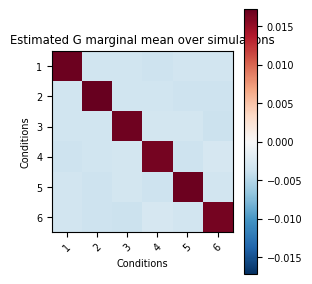

In [132]:
partitions = np.unique(D[0].obs_descriptors['part_vec'])
Y_marginal = np.zeros((nsim, 6*len(partitions), D[0].measurements.shape[1]))
part_vec = np.repeat(np.arange(len(partitions)), 6)
cond_vec = np.tile(np.arange(6), len(partitions))
for i in range(nsim):
    for p in partitions:
        for c in range(6):
            # select the part of full data D:
            idx = np.where((D[i].obs_descriptors['part_vec'] == p) & 
                           (D[i].obs_descriptors['cond_vec']>=(c)*6) & 
                           (D[i].obs_descriptors['cond_vec']<(c+1)*6))[0]
            Y_marginal[i, int(c + p*6), :] = np.mean(D[i].measurements[idx, :], axis=0)

G_hat_marginal = np.zeros((nsim, 6, 6))
for i in range(nsim):
    G_hat_marginal[i, :, :], _ = pcm.est_G_crossval(Y_marginal[i],
                                            cond_vec,
                                            part_vec,
                                            X=pcm.matrix.indicator(part_vec))

G_mean_marginal = np.mean(G_hat_marginal, axis=0)
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_mean_marginal))
vmax = np.max(np.abs(G_mean_marginal))
plt.imshow(G_mean_marginal, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated G marginal mean over simulations')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(6), labels=np.arange(1,7), rotation=45)
plt.yticks(ticks=np.arange(6), labels=np.arange(1,7))
plt.tight_layout()
plt.show()



#### compare OLS with estimated_G_marginal

In [ ]:
# OLS Model Fit:
X = np.vstack([Gc[0].flatten(), Gc[1].flatten(), Gc[2].flatten()]).T
W = []
for i in range(nsim):
    tmp_w = np.linalg.pinv((X.T@X)) @ X.T @ G_hat[i].flatten()
    W.append(tmp_w)
W = np.array(W)

# estimate variance from OLS:
var_contra_ols = W[:,0] * np.trace(Gc[0])/ncond
var_ipsi_ols = W[:,1] * np.trace(Gc[1])/ncond
var_interaction_ols = W[:,2] * np.trace(Gc[2])/ncond

# estimate variance from marginal G_hat:


### OLS

#### make components

1.428571428571428
1.4285714285714277


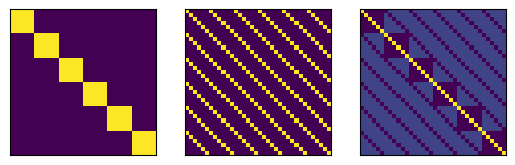

In [107]:
np.random.seed(0)
ncond = 36

# Generate the three model components, each one as a fixed model
A = np.zeros((ncond, 6))
for i in range(6):
    A[i*6:(i+1)*6, i] = 1.0
B = np.tile(np.eye(6), (6, 1))
I = np.eye(ncond)
# Orthogonalize the interaction effect
X = np.c_[A, B]
Io = I - X @ np.linalg.pinv(X) @ I

# Now Build the second moment matrix and create the full model
# for data generation:
Gc = np.zeros((3, ncond, ncond))
Gc[0] = A @ A.T
Gc[1] = B @ B.T
Gc[2] = Io @ Io.T

MC = pcm.ComponentModel('ABC', [Gc[0], Gc[1], Gc[2]])

# results_path = os.path.join('./results/MF_PCM/')

# if not os.path.exists(results_path):
#     os.makedirs(results_path)

# Show the three model components
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(Gc[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

D2 = pcm.G_to_dist(Gc[2])
# mean of diagonal - mean of off-diagonal:
avg = np.mean(np.diag(Gc[2])) - np.mean(Gc[2][np.where(~np.eye(Gc[2].shape[0],dtype=bool))])
print(avg*2.0)
print(np.sum(D2) / (ncond**2 - ncond))


#### component correlation

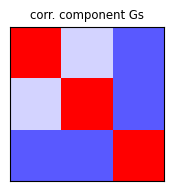

In [108]:
upper_Gs = [] 
for i in np.arange(3):
    upper_Gs.append(Gc[i][np.triu_indices(Gc[i].shape[0], k=1)]) 
upper_Gs = np.array(upper_Gs)
plt.figure(figsize=(2, 2))
plt.imshow(np.corrcoef(upper_Gs), cmap='bwr', vmin=-1, vmax=1)
plt.xticks([])
plt.yticks([])
plt.title('corr. component Gs')
plt.show()


#### generate data and fit components

In [109]:
nsim = 200
s = [0.02]*nsim
cond_vec, part_vec = pcm.sim.make_design(n_cond=ncond, n_part=10)
theta_true = np.array([0,-1000,0])

D = pcm.sim.make_dataset(model=MC,
    theta=theta_true,
    cond_vec=cond_vec,
    part_vec=part_vec,
    n_sim=nsim,
    n_channel=300,
    signal=s)

# estimate G_hat:
G_hat = np.zeros((nsim, ncond, ncond))
for i in range(nsim):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))

# PCM Model Fit:
M = [MC]
# T, theta = pcm.fit_model_individ(D, M, fixed_effect='block', verbose=False)
T, theta = fit_CKA_individ(D, M, fixed_effect='block', verbose=False)
T_pcm, theta_pcm = pcm.fit_model_individ(D, M, fit_scale=False, fixed_effect='block', verbose=False)

# OLS Model Fit:
X = np.vstack([Gc[0].flatten(), Gc[1].flatten(), Gc[2].flatten()]).T
W = []
for i in range(nsim):
    tmp_w = np.linalg.pinv((X.T@X)) @ X.T @ G_hat[i].flatten()
    W.append(tmp_w)
W = np.array(W)



#### plot

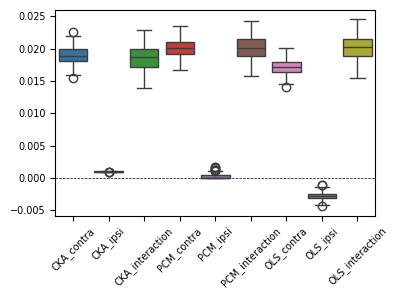

In [112]:
var_contra = np.exp(theta[0][0])
var_ipsi = np.exp(theta[0][1])
var_interaction = np.exp(theta[0][2])

var_contra2 = np.exp(theta_pcm[0][0])
var_ipsi2 = np.exp(theta_pcm[0][1])
var_interaction2 = np.exp(theta_pcm[0][2])

# sns boxplot of theta vs W
fig, ax = plt.subplots(figsize=(4,3))
data = pd.DataFrame({
    'CKA_contra': var_contra,
    'CKA_ipsi': var_ipsi,
    'CKA_interaction': var_interaction,
    'PCM_contra': var_contra2,
    'PCM_ipsi': var_ipsi2,
    'PCM_interaction': var_interaction2,
    'OLS_contra': W[:,0],
    'OLS_ipsi': W[:,1],
    'OLS_interaction': W[:,2],
})
sns.boxplot(data=data, ax=ax)
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
# plt.title('PCM vs OLS parameter estimates')
plt.tight_layout()
plt.show()


